# Functions

## Preprocessing function

- Image preprocessing, normalization , augmentation
- Text Standardization

In [1]:
arch = "puigcerver"

In [2]:
"""
Data preproc functions:
    adjust_to_see: adjust image to better visualize (rotate and transpose)
    augmentation: apply variations to a list of images
    text_standardize: preprocess and standardize sentence
    normalization: apply normalization and variations on images (if required)
    preprocess: main function for preprocess
"""

import re
import os
import cv2
import html
import string
import numpy as np


def adjust_to_see(img):
    """Rotate and transpose to image visualize (cv2 method or jupyter notebook)"""

    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), -90, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    img = cv2.warpAffine(img, M, (nW + 1, nH + 1))
    img = cv2.warpAffine(img.transpose(), M, (nW, nH))

    return img


def augmentation(imgs,
                 rotation_range=0,
                 scale_range=0,
                 height_shift_range=0,
                 width_shift_range=0,
                 dilate_range=1,
                 erode_range=1):
    """Apply variations to a list of images (rotate, width and height shift, scale, erode, dilate)"""

    imgs = imgs.astype(np.float32)
    _, h, w = imgs.shape

    dilate_kernel = np.ones((int(np.random.uniform(1, dilate_range)),), np.uint8)
    erode_kernel = np.ones((int(np.random.uniform(1, erode_range)),), np.uint8)
    height_shift = np.random.uniform(-height_shift_range, height_shift_range)
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - scale_range, 1)
    width_shift = np.random.uniform(-width_shift_range, width_shift_range)

    trans_map = np.float32([[1, 0, width_shift * w], [0, 1, height_shift * h]])
    rot_map = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)

    trans_map_aff = np.r_[trans_map, [[0, 0, 1]]]
    rot_map_aff = np.r_[rot_map, [[0, 0, 1]]]
    affine_mat = rot_map_aff.dot(trans_map_aff)[:2, :]

    for i in range(len(imgs)):
        imgs[i] = cv2.warpAffine(imgs[i], affine_mat, (w, h), flags=cv2.INTER_NEAREST, borderValue=255)
        imgs[i] = cv2.erode(imgs[i], erode_kernel, iterations=1)
        imgs[i] = cv2.dilate(imgs[i], dilate_kernel, iterations=1)

    return imgs


"""
DeepSpell based text cleaning process.
    Tal Weiss.
    Deep Spelling.
    Medium: https://machinelearnings.co/deep-spelling-9ffef96a24f6#.2c9pu8nlm
    Github: https://github.com/MajorTal/DeepSpell
"""

RE_DASH_FILTER = re.compile(r'[\-\˗\֊\‐\‑\‒\–\—\⁻\₋\−\﹣\－]', re.UNICODE)
RE_APOSTROPHE_FILTER = re.compile(r'&#39;|[ʼ՚＇‘’‛❛❜ߴߵ`‵´ˊˋ{}{}{}{}{}{}{}{}{}]'.format(
    chr(768), chr(769), chr(832), chr(833), chr(2387),
    chr(5151), chr(5152), chr(65344), chr(8242)), re.UNICODE)
RE_RESERVED_CHAR_FILTER = re.compile(r'[¶¤«»]', re.UNICODE)
RE_LEFT_PARENTH_FILTER = re.compile(r'[\(\[\{\⁽\₍\❨\❪\﹙\（]', re.UNICODE)
RE_RIGHT_PARENTH_FILTER = re.compile(r'[\)\]\}\⁾\₎\❩\❫\﹚\）]', re.UNICODE)
RE_BASIC_CLEANER = re.compile(r'[^\w\s{}]'.format(re.escape(string.punctuation)), re.UNICODE)

LEFT_PUNCTUATION_FILTER = """!%&),.:;<=>?@\\]^_`|}~"""
RIGHT_PUNCTUATION_FILTER = """"(/<=>@[\\^_`{|~"""
NORMALIZE_WHITESPACE_REGEX = re.compile(r'[^\S\n]+', re.UNICODE)


def text_standardize(text):
    """Organize/add spaces around punctuation marks"""

    if text is None:
        return ""

    text = html.unescape(text).replace("\\n", "").replace("\\t", "")

    text = RE_RESERVED_CHAR_FILTER.sub("", text)
    text = RE_DASH_FILTER.sub("-", text)
    text = RE_APOSTROPHE_FILTER.sub("'", text)
    text = RE_LEFT_PARENTH_FILTER.sub("(", text)
    text = RE_RIGHT_PARENTH_FILTER.sub(")", text)
    text = RE_BASIC_CLEANER.sub("", text)

    text = text.lstrip(LEFT_PUNCTUATION_FILTER)
    text = text.rstrip(RIGHT_PUNCTUATION_FILTER)
    text = text.translate(str.maketrans({c: f" {c} " for c in string.punctuation}))
    text = NORMALIZE_WHITESPACE_REGEX.sub(" ", text.strip())

    return text


def normalization(imgs):
    """Normalize list of images"""

    imgs = np.asarray(imgs).astype(np.float32)
    _, h, w = imgs.shape

    for i in range(len(imgs)):
        m, s = cv2.meanStdDev(imgs[i])
        imgs[i] = imgs[i] - m[0][0]
        imgs[i] = imgs[i] / s[0][0] if s[0][0] > 0 else imgs[i]

    return np.expand_dims(imgs, axis=-1)


"""
Preprocess metodology based in:
    H. Scheidl, S. Fiel and R. Sablatnig,
    Word Beam Search: A Connectionist Temporal Classification Decoding Algorithm, in
    16th International Conference on Frontiers in Handwriting Recognition, pp. 256-258, 2018.
"""


def preprocess(img, input_size):
    """Make the process with the `input_size` to the scale resize"""

    def imread(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        u, i = np.unique(np.array(img).flatten(), return_inverse=True)
        background = int(u[np.argmax(np.bincount(i))])
        return img, background

    if isinstance(img, str):
        img, bg = imread(img)

    if isinstance(img, tuple):
        image, boundbox = img
        img, bg = imread(image)

        for i in range(len(boundbox)):
            if isinstance(boundbox[i], float):
                total = len(img) if i < 2 else len(img[0])
                boundbox[i] = int(total * boundbox[i])
            else:
                boundbox[i] = int(boundbox[i])

        img = np.asarray(img[boundbox[0]:boundbox[1], boundbox[2]:boundbox[3]], dtype=np.uint8)

    wt, ht, _ = input_size
    h, w = np.asarray(img).shape
    f = max((w / wt), (h / ht))

    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
    
    ### Only if you need ###
    #_, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img = cv2.resize(img, new_size)

    target = np.ones([ht, wt], dtype=np.uint8) * bg
    target[0:new_size[1], 0:new_size[0]] = img
    img = cv2.transpose(target)

    return img



## Read raw dataset and prepare h5py(hdf5) file

Read the raw dataset and fetch the ground truth text and image file to make h5py file

Note : This step is only require if you want to read raw dataset and change to hdf5 file formats

In [ ]:
"""Dataset reader and process"""

import os
import html
import h5py
import string
import random
import numpy as np
import multiprocessing
import xml.etree.ElementTree as ET

from glob import glob
from tqdm import tqdm
from functools import partial


class Dataset():
    """Dataset class to read images and sentences from base (raw files)"""

    def __init__(self, source, name):
        self.source = source ## path to the dataset
        self.name = name
        self.dataset = None
        self.partitions = ['train', 'valid', 'test']

    def read_partitions(self):
        """Read images and sentences from dataset"""

        dataset = getattr(self, f"_{self.name}")() ## the result is the _washington

        
        if not self.dataset:
            self.dataset = self._init_dataset()

        for y in self.partitions:
            self.dataset[y]['dt'] += dataset[y]['dt']
            self.dataset[y]['gt'] += dataset[y]['gt']
        
        

    def save_partitions(self, target, image_input_size, max_text_length):
        """Save images and sentences from dataset"""

        os.makedirs(os.path.dirname(target), exist_ok=True) ## check hdf5 or not
        total = 0

        with h5py.File(target, "w") as hf:
            for pt in self.partitions:
                self.dataset[pt] = self.check_text(self.dataset[pt], max_text_length) ## check the sentence length
                size = (len(self.dataset[pt]['dt']),) + image_input_size[:2]
                total += size[0]

                dummy_image = np.zeros(size, dtype=np.uint8)
                dummy_sentence = [("c" * max_text_length).encode()] * size[0]

                hf.create_dataset(f"{pt}/dt", data=dummy_image, compression="gzip", compression_opts=9)
                hf.create_dataset(f"{pt}/gt", data=dummy_sentence, compression="gzip", compression_opts=9)

        pbar = tqdm(total=total)
        batch_size = 1024

        for pt in self.partitions:
            for batch in range(0, len(self.dataset[pt]['gt']), batch_size):
                images = []

                with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
                    r = pool.map(partial(preprocess, input_size=image_input_size),
                                 self.dataset[pt]['dt'][batch:batch + batch_size])
                    images.append(r)
                    pool.close()
                    pool.join()

                with h5py.File(target, "a") as hf:
                    hf[f"{pt}/dt"][batch:batch + batch_size] = images
                    hf[f"{pt}/gt"][batch:batch + batch_size] = [s.encode() for s in self.dataset[pt]
                                                                ['gt'][batch:batch + batch_size]]
                    pbar.update(batch_size)

    def _init_dataset(self):
        dataset = dict()
        

        for i in self.partitions:
            dataset[i] = {"dt": [], "gt": []}

        return dataset

    def _shuffle(self, *ls):
        random.seed(42)

        if len(ls) == 1:
            li = list(*ls)
            random.shuffle(li)
            return li

        li = list(zip(*ls))
        random.shuffle(li)
        return zip(*li)



    def _bentham(self):
        """Bentham dataset reader"""

        source = os.path.join(self.source, "BenthamDatasetR0-GT")
        pt_path = os.path.join(source, "Partitions")

        paths = {"train": open(os.path.join(pt_path, "TrainLines.lst")).read().splitlines(),
                 "valid": open(os.path.join(pt_path, "ValidationLines.lst")).read().splitlines(),
                 "test": open(os.path.join(pt_path, "TestLines.lst")).read().splitlines()}

        transcriptions = os.path.join(source, "Transcriptions")
        gt = os.listdir(transcriptions)
        gt_dict = dict()

        for index, x in enumerate(gt):
            text = " ".join(open(os.path.join(transcriptions, x)).read().splitlines())
            text = html.unescape(text).replace("<gap/>", "")
            gt_dict[os.path.splitext(x)[0]] = " ".join(text.split())

        img_path = os.path.join(source, "Images", "Lines")
        dataset = self._init_dataset()

        for i in self.partitions:
            for line in paths[i]:
                dataset[i]['dt'].append(os.path.join(img_path, f"{line}.png"))
                dataset[i]['gt'].append(gt_dict[line])

        return dataset

    def _iam(self):
        """IAM dataset reader"""

        pt_path = os.path.join(self.source, "largeWriterIndependentTextLineRecognitionTask")
        paths = {"train": open(os.path.join(pt_path, "trainset.txt")).read().splitlines(),
                 "valid": open(os.path.join(pt_path, "validationset1.txt")).read().splitlines() +
                 open(os.path.join(pt_path, "validationset2.txt")).read().splitlines(),
                 "test": open(os.path.join(pt_path, "testset.txt")).read().splitlines()}

        lines = open(os.path.join(self.source, "ascii", "lines.txt")).read().splitlines()
        dataset = self._init_dataset()
        gt_dict = dict()

        for line in lines:
            if (not line or line[0] == "#"):
                continue

            split = line.split()
            gt_dict[split[0]] = " ".join(split[8::]).replace("|", " ")

        for i in self.partitions:
            for line in paths[i]:
                try:
                    split = line.split("-")
                    folder = f"{split[0]}-{split[1]}"

                    img_file = f"{split[0]}-{split[1]}-{split[2]}.png"
                    img_path = os.path.join(self.source, "lines", split[0], folder, img_file)

                    dataset[i]['gt'].append(gt_dict[line])
                    dataset[i]['dt'].append(img_path)
                except KeyError:
                    pass

        return dataset

    def _saintgall(self):
        """Saint Gall dataset reader"""

        pt_path = os.path.join(self.source, "sets")

        paths = {"train": open(os.path.join(pt_path, "train.txt")).read().splitlines(),
                 "valid": open(os.path.join(pt_path, "valid.txt")).read().splitlines(),
                 "test": open(os.path.join(pt_path, "test.txt")).read().splitlines()}

        lines = open(os.path.join(self.source, "ground_truth", "transcription.txt")).read().splitlines()
        gt_dict = dict()

        for line in lines:
            split = line.split()
            split[1] = split[1].replace("-", "").replace("|", " ")
            gt_dict[split[0]] = split[1]

        img_path = os.path.join(self.source, "data", "line_images_normalized")
        dataset = self._init_dataset()

        for i in self.partitions:
            for line in paths[i]:
                glob_filter = os.path.join(img_path, f"{line}*")
                img_list = [x for x in glob(glob_filter, recursive=True)]

                for line in img_list:
                    line = os.path.splitext(os.path.basename(line))[0]
                    dataset[i]['dt'].append(os.path.join(img_path, f"{line}.png"))
                    dataset[i]['gt'].append(gt_dict[line])

        return dataset

    def _washington(self):
        """Washington dataset reader"""

        pt_path = os.path.join(self.source, "sets", "cv1")

        paths = {"train": open(os.path.join(pt_path, "train.txt")).read().splitlines(), ## 270-01
                 "valid": open(os.path.join(pt_path, "valid.txt")).read().splitlines(),
                 "test": open(os.path.join(pt_path, "test.txt")).read().splitlines()}

        lines = open(os.path.join(self.source, "ground_truth", "transcription.txt")).read().splitlines()
        gt_dict = dict()

        for line in lines:
            ## text processing
            ## 270-12 O-c-t-o-b-e-r|s_2-s_6th-s_pt|s_GW
            split = line.split()
            split[1] = split[1].replace("-", "").replace("|", " ")
            split[1] = split[1].replace("s_pt", ".").replace("s_cm", ",")
            split[1] = split[1].replace("s_mi", "-").replace("s_qo", ":")
            split[1] = split[1].replace("s_sq", ";").replace("s_et", "V")
            split[1] = split[1].replace("s_bl", "(").replace("s_br", ")")
            split[1] = split[1].replace("s_qt", "'").replace("s_GW", "G.W.")
            split[1] = split[1].replace("s_", "")
            gt_dict[split[0]] = split[1]

        img_path = os.path.join(self.source, "data", "line_images_normalized")
        dataset = self._init_dataset()

        for i in self.partitions:
            for line in paths[i]:
                dataset[i]['dt'].append(os.path.join(img_path, f"{line}.png"))
                dataset[i]['gt'].append(gt_dict[line])

        return dataset

    @staticmethod
    def check_text(data, max_text_length=128):
        """Checks if the text has more characters instead of punctuation marks"""

        dt = {'gt': list(data['gt']), 'dt': list(data['dt'])}

        for i in reversed(range(len(dt['gt']))):
            text = text_standardize(dt['gt'][i])
            strip_punc = text.strip(string.punctuation).strip()
            no_punc = text.translate(str.maketrans("", "", string.punctuation)).strip()

            length_valid = (len(text) > 1) and (len(text) < max_text_length)
            text_valid = (len(strip_punc) > 1) and (len(no_punc) > 1)

            if (not length_valid) or (not text_valid): ## remove the sentence
                dt['gt'].pop(i)
                dt['dt'].pop(i)
                continue

        return dt


## Connecting google drive 

Connect the google drive and need to run once before runtime deletion

Note: Select your file path from your google drive

In [3]:
from google.colab import drive

drive.mount("/content/drive")

%cd "/content/drive/My Drive/Handwritten_Recognition/datasets_hdf5_format"

Mounted at /content/drive
/content/drive/My Drive/Handwritten_Recognition/datasets_hdf5_format


In [4]:
ls -l

total 676082
-rw------- 1 root root 460576219 Dec 31 14:04 bentham.hdf5
-rw------- 1 root root 215855398 Dec 31 14:04 iam.hdf5
-rw------- 1 root root  10278694 Dec 31 14:04 saintgall.hdf5
-rw------- 1 root root   5596697 Dec 31 14:04 washington.hdf5


## Get the image data and ground truth text from h5py file

Read the .hdf5 file and get the information about the image data in numpy format and ground truth text

In [5]:
## Dataset generator 

from itertools import groupby
import h5py
import numpy as np
import unicodedata


class DataGenerator():
    """Generator class with data streaming"""

    def __init__(self, source, batch_size, charset, max_text_length, predict=False, stream=False):
        self.tokenizer = Tokenizer(charset, max_text_length)
        self.batch_size = batch_size

        self.size = dict()
        self.steps = dict()
        self.index = dict()

        if stream:
            self.dataset = h5py.File(source, "r")

            for pt in ['train', 'valid', 'test']:
                self.size[pt] = self.dataset[pt]['gt'][:].shape[0]
                self.steps[pt] = int(np.ceil(self.size[pt] / self.batch_size))
        else:
            self.dataset = dict()

            with h5py.File(source, "r") as f:
                for pt in ['train', 'valid', 'test']:
                    self.dataset[pt] = dict()
                    self.dataset[pt]['dt'] = np.array(f[pt]['dt'])
                    self.dataset[pt]['gt'] = np.array(f[pt]['gt'])

                    self.size[pt] = len(self.dataset[pt]['gt'])
                    self.steps[pt] = int(np.ceil(self.size[pt] / self.batch_size))

        self.stream = stream
        self.arange = np.arange(len(self.dataset['train']['gt']))
        np.random.seed(42)

    def next_train_batch(self):
        """Get the next batch from train partition (yield)"""

        self.index['train'] = 0

        while True:
            if self.index['train'] >= self.size['train']:
                self.index['train'] = 0

                if not self.stream:
                    np.random.shuffle(self.arange)
                    self.dataset['train']['dt'] = self.dataset['train']['dt'][self.arange]
                    self.dataset['train']['gt'] = self.dataset['train']['gt'][self.arange]

            index = self.index['train']
            until = index + self.batch_size
            self.index['train'] = until

            x_train = self.dataset['train']['dt'][index:until]
            x_train = augmentation(x_train,
                                      rotation_range=1.5,
                                      scale_range=0.05,
                                      height_shift_range=0.025,
                                      width_shift_range=0.05,
                                      erode_range=5,
                                      dilate_range=3)
            x_train = normalization(x_train)

            y_train = [self.tokenizer.encode(y) for y in self.dataset['train']['gt'][index:until]]
            y_train = [np.pad(y, (0, self.tokenizer.maxlen - len(y))) for y in y_train]
            y_train = np.asarray(y_train, dtype=np.int16)

            yield (x_train, y_train)

    def next_valid_batch(self):
        """Get the next batch from validation partition (yield)"""

        self.index['valid'] = 0

        while True:
            if self.index['valid'] >= self.size['valid']:
                self.index['valid'] = 0

            index = self.index['valid']
            until = index + self.batch_size
            self.index['valid'] = until

            x_valid = self.dataset['valid']['dt'][index:until]
            x_valid = normalization(x_valid)

            y_valid = [self.tokenizer.encode(y) for y in self.dataset['valid']['gt'][index:until]]
            y_valid = [np.pad(y, (0, self.tokenizer.maxlen - len(y))) for y in y_valid]
            y_valid = np.asarray(y_valid, dtype=np.int16)

            yield (x_valid, y_valid)

    def next_test_batch(self):
        """Return model predict parameters"""

        self.index['test'] = 0

        while True:
            if self.index['test'] >= self.size['test']:
                self.index['test'] = 0
                break

            index = self.index['test']
            until = index + self.batch_size
            self.index['test'] = until

            x_test = self.dataset['test']['dt'][index:until]
            x_test = normalization(x_test)

            yield x_test


class Tokenizer():
    """Manager tokens functions and charset/dictionary properties"""

    def __init__(self, chars, max_text_length=128):
        self.PAD_TK, self.UNK_TK = "¶", "¤"
        self.chars = (self.PAD_TK + self.UNK_TK + chars)

        self.PAD = self.chars.find(self.PAD_TK)
        self.UNK = self.chars.find(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length

    def encode(self, text):
        """Encode text to vector"""

        if isinstance(text, bytes):
            text = text.decode()

        text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("ASCII")
        text = " ".join(text.split())

        groups = ["".join(group) for _, group in groupby(text)]
        text = "".join([self.UNK_TK.join(list(x)) if len(x) > 1 else x for x in groups])
        encoded = []

        for item in text:
            index = self.chars.find(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)

        return np.asarray(encoded)

    def decode(self, text):
        """Decode vector to text"""

        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)

        return decoded

    def remove_tokens(self, text):
        """Remove tokens (PAD) from text"""

        return text.replace(self.PAD_TK, "").replace(self.UNK_TK, "")

## Neural Network building

In [6]:
"""Model 1 - Handwritten Text Recognition Neural Network"""

import os
import logging

try:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
    logging.disable(logging.WARNING)
except AttributeError:
    pass

import numpy as np
import tensorflow as tf

from contextlib import redirect_stdout
from tensorflow.keras import backend as K
from tensorflow.keras import Model

from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.constraints import MaxNorm

# from network.layers import FullGatedConv2D, GatedConv2D, OctConv2D
from tensorflow.keras.layers import Conv2D, Bidirectional, LSTM, GRU, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, PReLU
from tensorflow.keras.layers import Input, Add, Activation, Lambda, MaxPooling2D, Reshape


def puigcerver(input_size, d_model):
    """
    Convolucional Recurrent Neural Network by Puigcerver et al.

    Reference:
        Joan Puigcerver.
        Are multidimensional recurrent layers really necessary for handwritten text recognition?
        In: Document Analysis and Recognition (ICDAR), 2017 14th
        IAPR International Conference on, vol. 1, pp. 67–72. IEEE (2017)

        Carlos Mocholí Calvo and Enrique Vidal Ruiz.
        Development and experimentation of a deep learning system for convolutional and recurrent neural networks
        Escola Tècnica Superior d’Enginyeria Informàtica, Universitat Politècnica de València, 2018
    """

    input_data = Input(name="input", shape=input_size)

    cnn = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same")(input_data)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(cnn)

    cnn = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(cnn)

    cnn = Dropout(rate=0.2)(cnn)
    cnn = Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(cnn)

    cnn = Dropout(rate=0.2)(cnn)
    cnn = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)

    cnn = Dropout(rate=0.2)(cnn)
    cnn = Conv2D(filters=80, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)

    shape = cnn.get_shape()
    blstm = Reshape((shape[1], shape[2] * shape[3]))(cnn)

    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)

    blstm = Dropout(rate=0.5)(blstm)
    output_data = Dense(units=d_model, activation="softmax")(blstm)

    return (input_data, output_data)

In [7]:

class HTRModel:

    def __init__(self,
                 architecture,
                 input_size,
                 vocab_size,
                 greedy=False,
                 beam_width=10,
                 top_paths=1,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1,
                 reduce_cooldown=0):
        """
        Initialization of a HTR Model.

        :param
            architecture: option of the architecture model to build and compile
            greedy, beam_width, top_paths: Parameters of the CTC decoding
            (see ctc decoding tensorflow for more details)
        """

        self.architecture = globals()[architecture]
        self.input_size = input_size
        self.vocab_size = vocab_size

        self.model = None
        self.greedy = greedy
        self.beam_width = beam_width
        self.top_paths = max(1, top_paths)

        self.stop_tolerance = stop_tolerance
        self.reduce_tolerance = reduce_tolerance
        self.reduce_factor = reduce_factor
        self.reduce_cooldown = reduce_cooldown

    def summary(self, output=None, target=None):
        """Show/Save model structure (summary)"""

        self.model.summary()

        if target is not None:
            os.makedirs(output, exist_ok=True)

            with open(os.path.join(output, target), "w") as f:
                with redirect_stdout(f):
                    self.model.summary()

    def load_checkpoint(self, target):
        """ Load a model with checkpoint file"""

        if os.path.isfile(target):
            if self.model is None:
                self.compile()

            self.model.load_weights(target)

    def get_callbacks(self, logdir, checkpoint, monitor="val_loss", verbose=0):
        """Setup the list of callbacks for the model"""

        callbacks = [
            CSVLogger(
                filename=os.path.join(logdir, "epochs.log"),
                separator=";",
                append=True),
            TensorBoard(
                log_dir=logdir,
                histogram_freq=10,
                profile_batch=0,
                write_graph=True,
                write_images=False,
                update_freq="epoch"),
            ModelCheckpoint(
                filepath=checkpoint,
                monitor=monitor,
                save_best_only=True,
                save_weights_only=True,
                verbose=verbose),
            EarlyStopping(
                monitor=monitor,
                min_delta=1e-8,
                patience=self.stop_tolerance,
                restore_best_weights=True,
                verbose=verbose),
            ReduceLROnPlateau(
                monitor=monitor,
                min_delta=1e-8,
                factor=self.reduce_factor,
                patience=self.reduce_tolerance,
                cooldown=self.reduce_cooldown,
                verbose=verbose)
        ]

        return callbacks

    def compile(self, learning_rate=None, initial_step=0):
        """
        Configures the HTR Model for training/predict.

        :param optimizer: optimizer for training
        """

        # define inputs, outputs and optimizer of the chosen architecture
        inputs, outputs = self.architecture(self.input_size, self.vocab_size + 1)

        if learning_rate is None:
            learning_rate = CustomSchedule(d_model=self.vocab_size + 1, initial_step=initial_step)
            self.learning_schedule = True
        else:
            self.learning_schedule = False

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

        # create and compile
        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=optimizer, loss=self.ctc_loss_lambda_func)

    def fit(self,
            x=None,
            y=None,
            batch_size=None,
            epochs=1,
            verbose=1,
            callbacks=None,
            validation_split=0.0,
            validation_data=None,
            shuffle=True,
            class_weight=None,
            sample_weight=None,
            initial_epoch=0,
            steps_per_epoch=None,
            validation_steps=None,
            validation_freq=1,
            max_queue_size=10,
            workers=1,
            use_multiprocessing=False,
            **kwargs):
        """
        Model training on data yielded (fit function has support to generator).
        A fit() abstration function of TensorFlow 2.

        Provide x parameter of the form: yielding (x, y, sample_weight).

        :param: See tensorflow.keras.Model.fit()
        :return: A history object
        """

        # remove ReduceLROnPlateau (if exist) when use schedule learning rate
        if callbacks and self.learning_schedule:
            callbacks = [x for x in callbacks if not isinstance(x, ReduceLROnPlateau)]

        out = self.model.fit(x=x, y=y, batch_size=batch_size, epochs=epochs, verbose=verbose,
                             callbacks=callbacks, validation_split=validation_split,
                             validation_data=validation_data, shuffle=shuffle,
                             class_weight=class_weight, sample_weight=sample_weight,
                             initial_epoch=initial_epoch, steps_per_epoch=steps_per_epoch,
                             validation_steps=validation_steps, validation_freq=validation_freq,
                             max_queue_size=max_queue_size, workers=workers,
                             use_multiprocessing=use_multiprocessing, **kwargs)
        return out

    def predict(self,
                x,
                batch_size=None,
                verbose=0,
                steps=1,
                callbacks=None,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=False,
                ctc_decode=True):
        """
        Model predicting on data yielded (predict function has support to generator).
        A predict() abstration function of TensorFlow 2.

        Provide x parameter of the form: yielding [x].

        :param: See tensorflow.keras.Model.predict()
        :return: raw data on `ctc_decode=False` or CTC decode on `ctc_decode=True` (both with probabilities)
        """

        if verbose == 1:
            print("Model Predict")

        out = self.model.predict(x=x, batch_size=batch_size, verbose=verbose, steps=steps,
                                 callbacks=callbacks, max_queue_size=max_queue_size,
                                 workers=workers, use_multiprocessing=use_multiprocessing)

        if not ctc_decode:
            return np.log(out.clip(min=1e-8)), []

        steps_done = 0
        if verbose == 1:
            print("CTC Decode")
            progbar = tf.keras.utils.Progbar(target=steps)

        batch_size = int(np.ceil(len(out) / steps))
        input_length = len(max(out, key=len))

        predicts, probabilities = [], []

        while steps_done < steps:
            index = steps_done * batch_size
            until = index + batch_size

            x_test = np.asarray(out[index:until])
            x_test_len = np.asarray([input_length for _ in range(len(x_test))])

            decode, log = K.ctc_decode(x_test,
                                       x_test_len,
                                       greedy=self.greedy,
                                       beam_width=self.beam_width,
                                       top_paths=self.top_paths)

            probabilities.extend([np.exp(x) for x in log])
            decode = [[[int(p) for p in x if p != -1] for x in y] for y in decode]
            predicts.extend(np.swapaxes(decode, 0, 1))

            steps_done += 1
            if verbose == 1:
                progbar.update(steps_done)

        return (predicts, probabilities)

    @staticmethod
    def ctc_loss_lambda_func(y_true, y_pred):
        """Function for computing the CTC loss"""

        if len(y_true.shape) > 2:
            y_true = tf.squeeze(y_true)

        # y_pred.shape = (batch_size, string_length, alphabet_size_1_hot_encoded)
        # output of every model is softmax
        # so sum across alphabet_size_1_hot_encoded give 1
        #               string_length give string length
        input_length = tf.math.reduce_sum(y_pred, axis=-1, keepdims=False)
        input_length = tf.math.reduce_sum(input_length, axis=-1, keepdims=True)

        # y_true strings are padded with 0
        # so sum of non-zero gives number of characters in this string
        label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True, dtype="int64")

        loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

        # average loss across all entries in the batch
        loss = tf.reduce_mean(loss)

        return loss

## Metric code 

In [8]:
import string
import unicodedata
import editdistance
import numpy as np


def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):
        pd, gt = pd.lower(), gt.lower()

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd), list(gt)
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.split(), gt.split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    metrics = [cer, wer, ser]
    metrics = np.mean(metrics, axis=1)

    return metrics


End of functions for dataset preparation.

Code For changing HDF File

In [ ]:
'''
source = "washington"
raw_path = os.path.join("input_data",  "raw", source)
'''

In [ ]:
'''
ds = Dataset(source=raw_path, name=source)
'''

In [ ]:
'''
print(f"The source is {ds.source}")
print(f"The name is {ds.name}")
print(f"The datasetis {ds.dataset}")
print(f"The partitions is {ds.partitions}")
'''

The source is input_data/raw/washington
The name is washington
The datasetis None
The partitions is ['train', 'valid', 'test']


In [ ]:
'''
ds.read_partitions()
'''

In [ ]:
'''
source_path = os.path.join( "data", f"{source}.hdf5")
input_size = (1024, 128, 1)
max_text_length = 128
'''

In [ ]:
'''
ds.save_partitions(source_path, input_size, max_text_length)
'''

3072it [02:43, 18.78it/s]


# 1. Washington Dataset

## 1.1 Dataset Preparation

Training on Washington Dataset

In [9]:
import os
import datetime
import string

# define parameters
source = "washigton"
epochs = 1000
batch_size = 16

# define paths
source_path = os.path.join( "data", f"{source}.hdf5")
output_path = os.path.join( "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: data/washigton.hdf5
output output/washigton/puigcerver
target output/washigton/puigcerver/checkpoint_weights.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


The second class is **DataGenerator()**, responsible for:

* Load the dataset partitions (train, valid, test);

* Manager batchs for train/validation/test process.

## 1.2 Dataset Generatior

In [12]:
source_path = "washington.hdf5"

In [13]:
dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 325
Validation images: 168
Test images: 163


## 1.3 Model Architecture

In [14]:
# create and compile HTRModel
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.001)
model.summary(output_path, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1024, 128, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 1024, 128, 16)     160       
                                                                 
 batch_normalization (BatchN  (None, 1024, 128, 16)    64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024, 128, 16)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 64, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 64, 32)       4640  

## 1.4 Training

The training process is similar to the *fit()* of the Keras. After training, the information (epochs and minimum loss) is save.

In [15]:
output_path

'output/washigton/puigcerver'

In [ ]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/1000
21/21 [==============================] - ETA: 0s - loss: 235.4751
Epoch 1: val_loss improved from inf to 213.94612, saving model to output/washigton/puigcerver/checkpoint_weights.hdf5
21/21 [==============================] - 37s 519ms/step - loss: 235.4751 - val_loss: 213.9461 - lr: 0.0010
Epoch 2/1000
21/21 [==============================] - ETA: 0s - loss: 205.6475
Epoch 2: val_loss improved from 213.94612 to 182.44778, saving model to output/washigton/puigcerver/checkpoint_weights.hdf5
21/21 [==============================] - 5s 233ms/step - loss: 205.6475 - val_loss: 182.4478 - lr: 0.0010
Epoch 3/1000
21/21 [==============================] - ETA: 0s - loss: 184.4700
Epoch 3: val_loss improved from 182.44778 to 140.79402, saving model to output/washigton/puigcerver/checkpoint_weights.hdf5
21/21 [==============================] - 4s 206ms/step - loss: 184.4700 - val_loss: 140.7940 - lr: 0.0010
Epoch 4/1000
21/21 [==============================] - ETA: 0s - loss: 137.9957

## 1.5 prediction

The predict process is similar to the *predict* of the Keras:

Model Predict
11/11 [==============================] - 4s 92ms/step
CTC Decode
 1/11 [=>............................] - ETA: 10s

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


11/11 [==============================] - 11s 1s/step



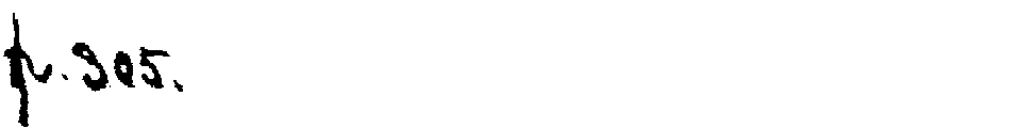

p.305
fi Vae. 




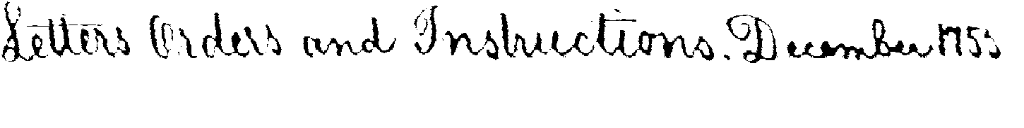

Letters Orders and Instructions. December 1755.
Laeltes Ordes and Instructions Farcvmber 2. 




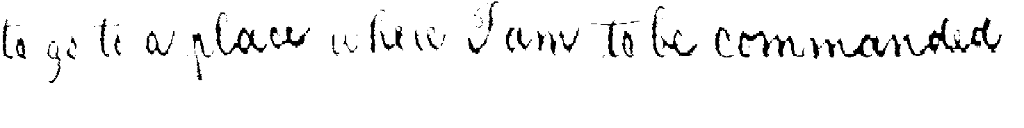

to go to a place where I am to be commanded
lo ge to a place where I am to be commandid 




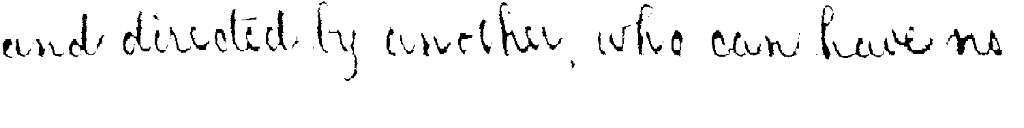

and directed by another, who can have no
and diseded by cmother; who can have noe 




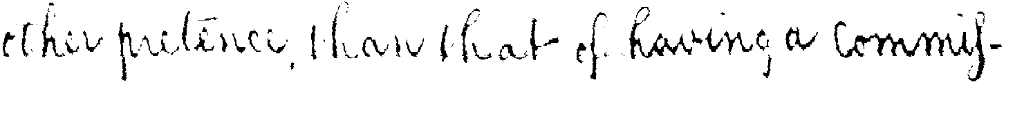

other pretence, than that of having a commis-
other pailince, than that of having a tComms 




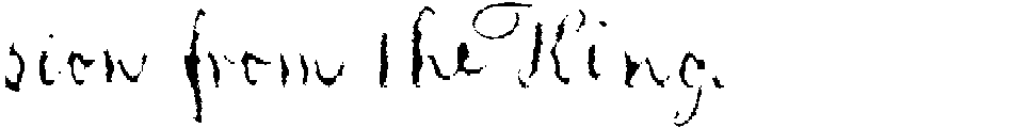

sion from the King.
sn from tht Fy5. 




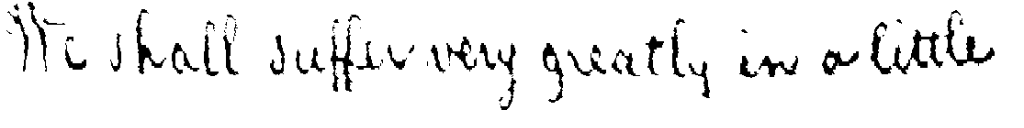

We shall suffer very greatly in a little
Yo shalt suffer very gurly in a lille 




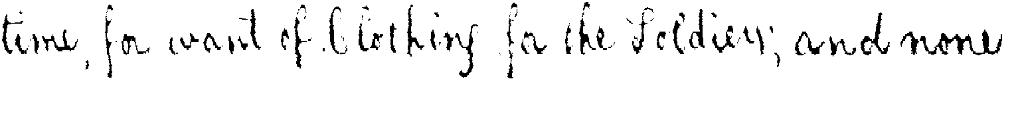

time, for want of Clothing for the Soldiers; and none
time, for wnd of Clothing for the Solliers, and wone 




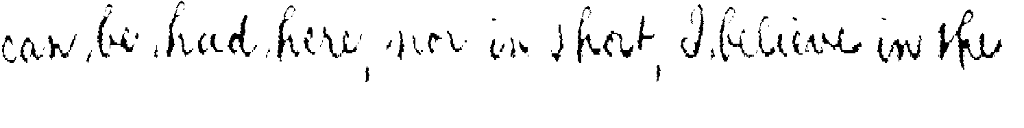

can be had here, nor in short, I believe in the
san, he had he, on in shoat, S leletere in the 




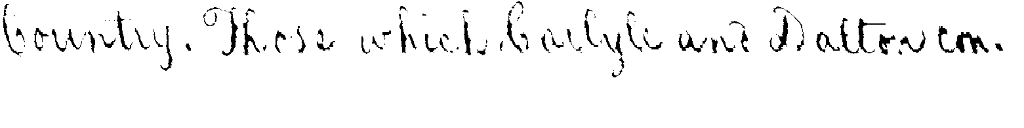

Country. Those which Carlyle and Dalton con-
Country Tose which Calgle and Dallors rom- 



In [ ]:
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
   
for i, item in enumerate(dtgen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")
    cv2_imshow(adjust_to_see(item))
    print(ground_truth[i])
    print(predicts[i], "\n")

In [ ]:
predicts[10]

'laeled to fromish, are are disapsonted in; and'

In [ ]:
ground_truth[10]

'tracted to furnish, we are disappointed in; and'

In [ ]:
print(len(predicts), len(ground_truth))

163 163


## 1.6 Evaluation

Evaluation process is more manual process. Here we have the `ocr_metrics`, but feel free to implement other metrics instead. In the function, we have three parameters: 

* predicts
* ground_truth
* norm_accentuation (calculation with/without accentuation)
* norm_punctuation (calculation with/without punctuation marks)

In [ ]:
evaluate = ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    163
Total time:           0:00:49.172022
Time per item:        0:00:00.301669

Metrics:
Character Error Rate: 0.24485306
Word Error Rate:      0.54937677
Sequence Error Rate:  0.99386503


# 2. saintgall Dataset


## 2.1 Datset Preparation

In [ ]:
import os
import datetime
import string

# define parameters
source = "saintgall"

epochs = 1000
batch_size = 16

# define paths
source_path = os.path.join("data", f"{source}.hdf5")
output_path = os.path.join( "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: data/saintgall.hdf5
output output/saintgall/puigcerver
target output/saintgall/puigcerver/checkpoint_weights.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


## 2.2 DataSet Generator

In [16]:
source_path = "saintgall.hdf5"

In [17]:
dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 468
Validation images: 235
Test images: 707


## 2.3 Model Architecture

In [18]:
# create and compile HTRModel
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.001)
model.summary(output_path, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1024, 128, 1)]    0         
                                                                 
 conv2d_5 (Conv2D)           (None, 1024, 128, 16)     160       
                                                                 
 batch_normalization_5 (Batc  (None, 1024, 128, 16)    64        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024, 128, 16)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 512, 64, 16)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 512, 64, 32)       4640

## 2.4 Training

In [19]:
output_path

'output/washigton/puigcerver'

In [20]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/1000



KeyboardInterrupt



## 2.5 prediction

Model Predict
45/45 [==============================] - 7s 57ms/step
CTC Decode
45/45 [==============================] - 54s 1s/step



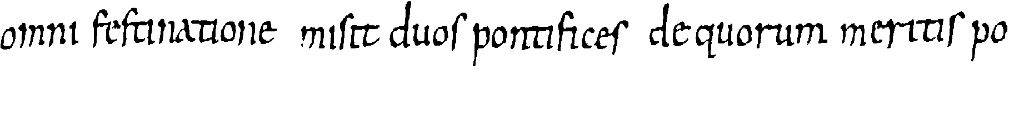

omni festinatione misit duos pontifices de quorum meritis po
omni festinatione misit duos pontifices de quorum meritis po 




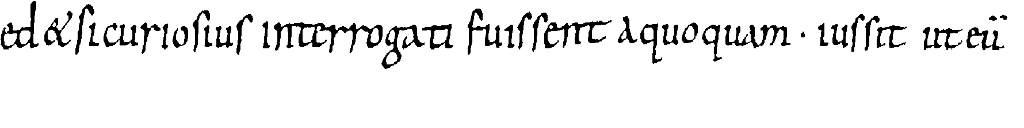

ed et si curiosius interrogati fuissent a quoquam iussit ut eu
el et sicuriosius interrogati fuissent aquoquampt iussit ut eu 




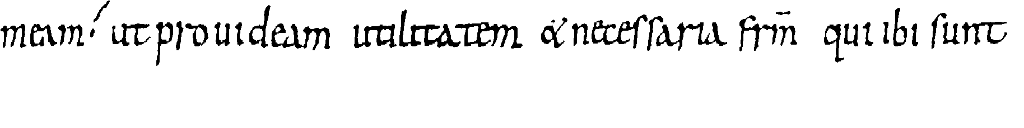

meam ut provideam utilitatem et necessaria frm qui ibi sunt
meampt ut provideam utilitatem et necessaria frm qui ibi sunt 




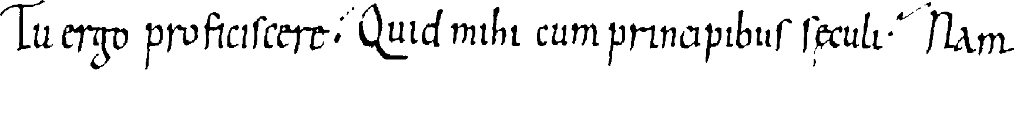

Tu ergo proficiscere Quid mihi cum principibus seculi Nam
lu ergo proficiscerept Quid mihi cum principibus feculipt Ham 




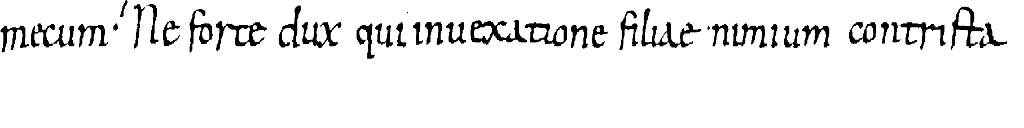

mecum ne forte dux qui in vexatione filiae nimium contrista
mecumpt He forte dux qui invexatione filiae minium contriftia 




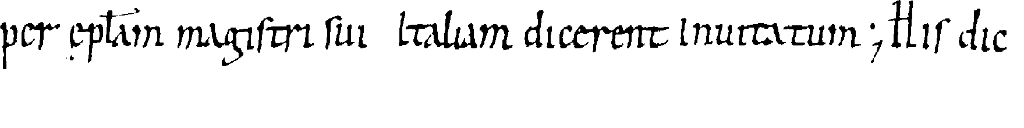

per eplam magistri sui italiam dicerent invitatum His dic
per epsam magistri sui italam dicerent invitatumpt Hs dic 




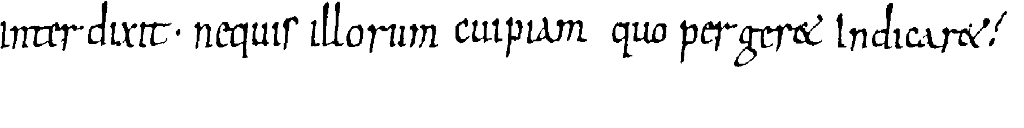

interdixit ne quis illorum cuipiam quo pergeret indicaret
inter dixitpt nequis illorum cuipiam quo pergeret indicaretpt 




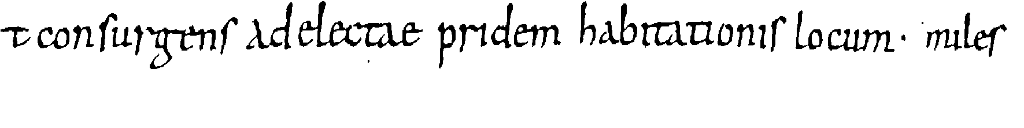

t consurgens ad electae pridem habitationis locum miles
t consurgens adelectae pridem habitationis locumpt miles 




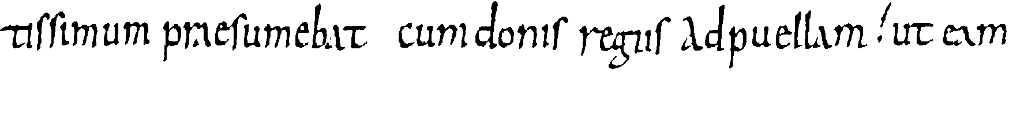

tissimum praesumebat cum donis regiis ad puellam ut eam
tissimum presumebat cum donis regus ad puellampt ut eam 




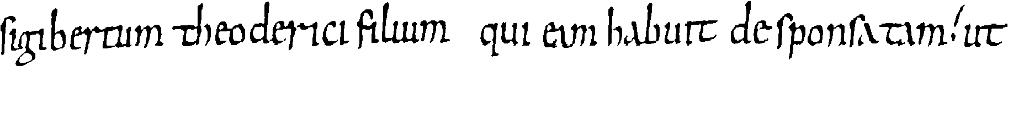

sigibertum theoderici filium qui eam habuit desponsatam ut
sigibertum theoderici filum qui eam habuit de sponsatampt ut 



In [ ]:
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
   
for i, item in enumerate(dtgen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")
    cv2_imshow(adjust_to_see(item))
    print(ground_truth[i])
    print(predicts[i], "\n")

## 2.6 Evaluation

In [ ]:
import string
import unicodedata
import editdistance
import numpy as np


def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):
        pd, gt = pd.lower(), gt.lower()

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd), list(gt)
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.split(), gt.split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    metrics = [cer, wer, ser]
    metrics = np.mean(metrics, axis=1)

    return metrics


In [ ]:
evaluate = ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    707
Total time:           0:01:37.492979
Time per item:        0:00:00.137897

Metrics:
Character Error Rate: 0.08846771
Word Error Rate:      0.38661191
Sequence Error Rate:  0.99151344


# bentham dataset

## 3.1 Dataset Preparation

In [ ]:
import os
import datetime
import string

# define parameters
source = "bentham"

epochs = 1000
batch_size = 16

# define paths
source_path = os.path.join("data", f"{source}.hdf5")
output_path = os.path.join( "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: data/bentham.hdf5
output output/bentham/puigcerver
target output/bentham/puigcerver/checkpoint_weights.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


## 3.2 Dataset Generator

In [ ]:
source_path = "bentham.hdf5"

In [ ]:
dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 8807
Validation images: 1372
Test images: 820


## 3.3 Model Architecture

In [ ]:
# create and compile HTRModel
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.001)
model.summary(output_path, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1024, 128, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 1024, 128, 16)     160       
                                                                 
 batch_normalization (BatchN  (None, 1024, 128, 16)    64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024, 128, 16)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 64, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 64, 32)       4640  

## 3.4 Training

In [ ]:
output_path

'output/bentham/puigcerver'

In [ ]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/1000
551/551 [==============================] - ETA: 0s - loss: 146.8924
Epoch 1: val_loss improved from inf to 128.23441, saving model to output/bentham/puigcerver/checkpoint_weights.hdf5
551/551 [==============================] - 131s 192ms/step - loss: 146.8924 - val_loss: 128.2344 - lr: 0.0010
Epoch 2/1000
551/551 [==============================] - ETA: 0s - loss: 111.5587
Epoch 2: val_loss improved from 128.23441 to 91.59689, saving model to output/bentham/puigcerver/checkpoint_weights.hdf5
551/551 [==============================] - 98s 179ms/step - loss: 111.5587 - val_loss: 91.5969 - lr: 0.0010
Epoch 3/1000
551/551 [==============================] - ETA: 0s - loss: 86.2788
Epoch 3: val_loss improved from 91.59689 to 75.24026, saving model to output/bentham/puigcerver/checkpoint_weights.hdf5
551/551 [==============================] - 102s 185ms/step - loss: 86.2788 - val_loss: 75.2403 - lr: 0.0010
Epoch 4/1000
551/551 [==============================] - ETA: 0s - loss: 72.

## 3.5 prediction

Model Predict
52/52 [==============================] - 6s 64ms/step
CTC Decode
 1/52 [..............................] - ETA: 56s

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


52/52 [==============================] - 56s 1s/step



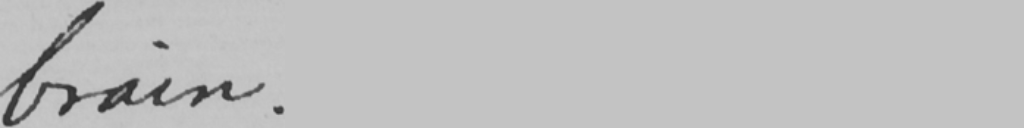

brain.
Crain . 




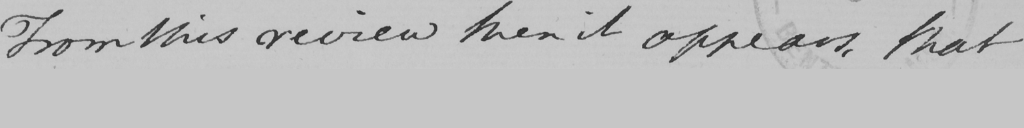

From this review then it appears, that
From this reirew then it appears that 




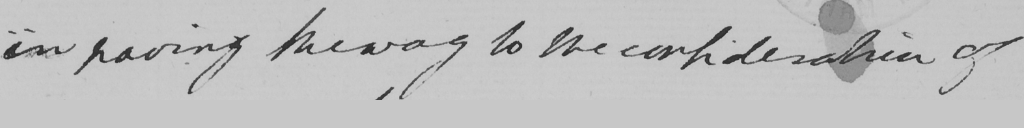

in paving the way to the consideration of
in paving heway to the conpderatic of 




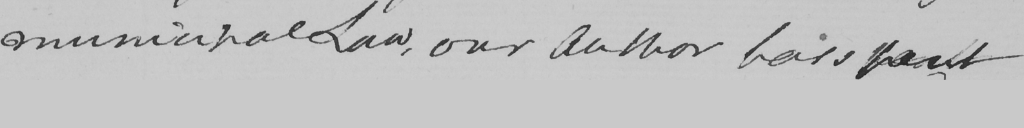

municipal Law, our Author has spent
municpal Law , our Author hars part 




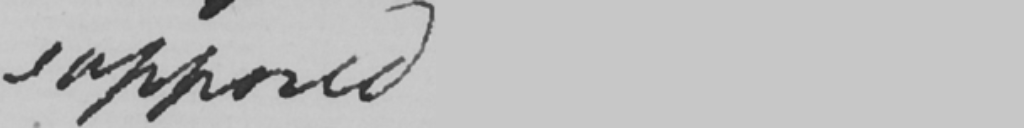

supposed
sappred 




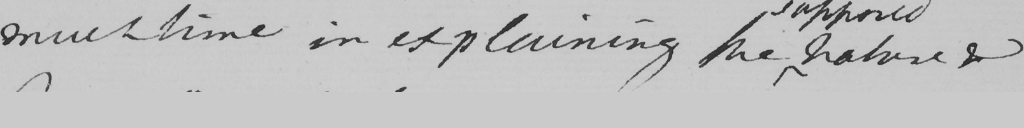

much time in explaining the nature &
onutime in explaining the nature  




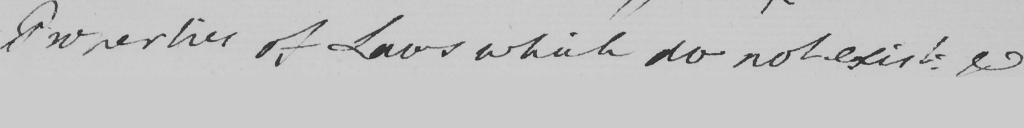

Properties of Laws which do not exist &
Everties of Laws whih do robexist : a 




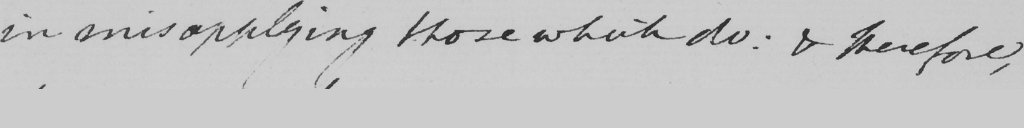

in misapplying those which do: & therefore,
in misapplying thore which de : o herefore ) 




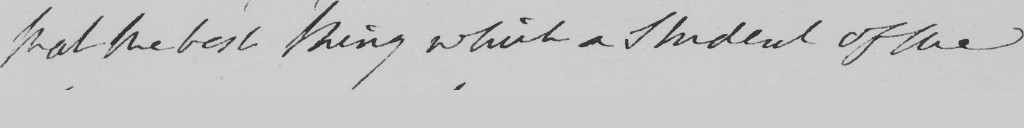

that the best thing which a Student of the
pal he best thing which a Student of due 




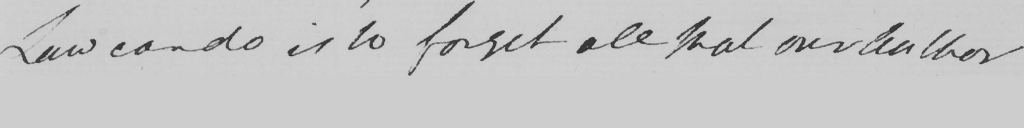

Law can do is to forget all that our Author
Law cando is to forset all pal our dather 



In [ ]:
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
   
for i, item in enumerate(dtgen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")
    cv2_imshow(adjust_to_see(item))
    print(ground_truth[i])
    print(predicts[i], "\n")

## 3.6 Evaluation

In [ ]:
evaluate = ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    820
Total time:           0:01:02.556162
Time per item:        0:00:00.076288

Metrics:
Character Error Rate: 0.07538685
Word Error Rate:      0.31930305
Sequence Error Rate:  0.80853659


# IAM dataset

## 4.1 Dataset Preparation

In [ ]:
import os
import datetime
import string

# define parameters
source = "iam"

epochs = 1000
batch_size = 16

# define paths
source_path = os.path.join("data", f"{source}.hdf5") ## preprocess  ## data/
output_path = os.path.join( "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.hdf5") ## checkpoint output
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: data/iam.hdf5
output output/iam/puigcerver
target output/iam/puigcerver/checkpoint_weights.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


## 4.2 Dataset generator

In [ ]:
source_path = "iam.hdf5"

dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 6161
Validation images: 1840
Test images: 1861


## 4.3 Model Architecture

In [ ]:
# create and compile HTRModel
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.001)
model.summary(output_path, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1024, 128, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 1024, 128, 16)     160       
                                                                 
 batch_normalization (BatchN  (None, 1024, 128, 16)    64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024, 128, 16)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 64, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 64, 32)       4640  

## 4.4 Training

In [ ]:
output_path

'output/iam/puigcerver'

In [ ]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/1000
386/386 [==============================] - ETA: 0s - loss: 159.3400
Epoch 1: val_loss improved from inf to 136.65799, saving model to output/iam/puigcerver/checkpoint_weights.hdf5
386/386 [==============================] - 104s 205ms/step - loss: 159.3400 - val_loss: 136.6580 - lr: 0.0010
Epoch 2/1000
386/386 [==============================] - ETA: 0s - loss: 120.4365
Epoch 2: val_loss did not improve from 136.65799
386/386 [==============================] - 75s 195ms/step - loss: 120.4365 - val_loss: 157.8126 - lr: 0.0010
Epoch 3/1000
386/386 [==============================] - ETA: 0s - loss: 104.0699
Epoch 3: val_loss improved from 136.65799 to 101.58734, saving model to output/iam/puigcerver/checkpoint_weights.hdf5
386/386 [==============================] - 79s 204ms/step - loss: 104.0699 - val_loss: 101.5873 - lr: 0.0010
Epoch 4/1000
386/386 [==============================] - ETA: 0s - loss: 93.2011
Epoch 4: val_loss improved from 101.58734 to 88.31357, saving model to

## 4.5 Prediction

In [ ]:
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
   
for i, item in enumerate(dtgen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")
    cv2_imshow(adjust_to_see(item))
    print(ground_truth[i])
    print(predicts[i], "\n")

## 4.6 Evaluation

In [ ]:
evaluate = ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)